#### Importamos librerías con las que trabajaremos

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import osmnx as ox
import sklearn.neighbors
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import folium
from folium.plugins import BeautifyIcon
from geopy.geocoders import Nominatim
import openpyxl

#### Descargamos fichero shp Región Metropolitana (RM)

In [3]:
# fichero shp con Comunas RM
rm_comunas = gpd.read_file('../GeoPython/Chile/Censo/R13/COMUNA_C17.shp')

In [4]:
# proyectamos coordenadas
rm_comunas.to_crs(4326, inplace=True)

#### Descargamos Data Electrolineras
- https://energia.gob.cl/electromovilidad/ecocarga

In [5]:
# fichero con Estaciones de Carga existentes
ev = pd.read_excel('../GeoPython/Chile/EV_Chargers/Electrolineras_Chile.xlsx')

In [6]:
# convertimos a GeoDataFrame
ev_gdf = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(ev['Longitud'], ev['Latitud'])}, crs='EPSG:4326').join(ev)

In [7]:
# solo nos quedamos con las electrolineras de la RM
ev_rm = ev_gdf.loc[ev_gdf["Región"].isin(['Metropolitana'])].copy()

In [8]:
# Nro. electrolineras en RM
len(ev_rm)

443

In [49]:
len(ev_rm.drop_duplicates(subset=['latitud'], keep='first'))

161

In [9]:
ev_rm.columns = ev_rm.columns.str.lower().str.replace(' ','_')

#### Definimos el área de estudio: eliminamos las comunas perifericas de la RM y nos quedamos con las más centricas

In [10]:
comunas_sel = rm_comunas.loc[~rm_comunas['NOM_COMUNA'].isin(['TILTIL','LAMPA', 'MARÍA PINTO', 'CURACAVÍ','CALERA DE TANGO',
                                                             'SAN JOSÉ DE MAIPO', 'PIRQUE','EL MONTE','TALAGANTE', 'SAN PEDRO', 'ALHUÉ',
                                                             'PAINE', 'BUIN','ISLA DE MAIPO','PEÑAFLOR', 'PADRE HURTADO','MELIPILLA'])].copy()

In [11]:
# disolvemos en un solo poligono
comunas_aoi = comunas_sel.dissolve()

In [12]:
ev_rm_clip = gpd.clip(ev_rm, comunas_aoi)

In [13]:
# Nro. electrolineras en comunas seleccionadas RM
len(ev_rm_clip)

404

In [14]:
ev_rm_clip = ev_rm_clip.reset_index(drop=True)

In [15]:
# corregimos typo del dataset original de electrolineras
ev_rm_clip.iloc[399,3] = 'Pudahuel'

In [16]:
comunas_sel['coords'] = comunas_sel['geometry'].apply(lambda x: x.representative_point().coords[:])
comunas_sel['coords'] = [coords[0] for coords in comunas_sel['coords']]

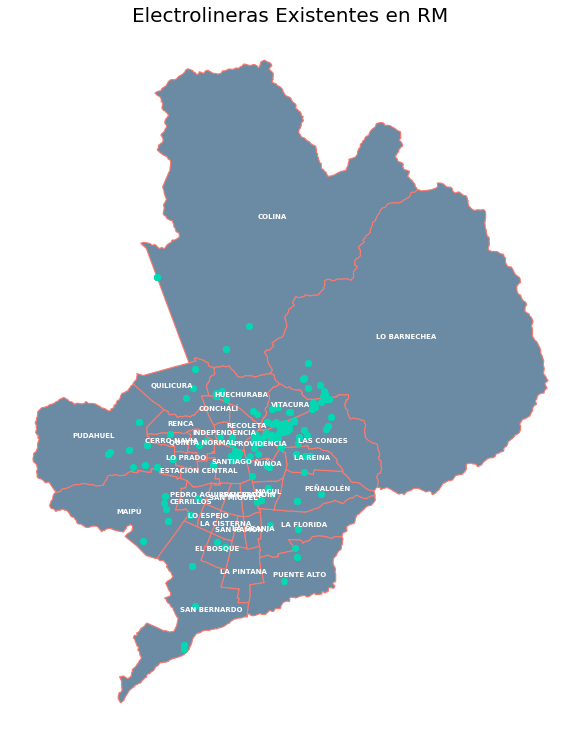

In [17]:
warnings.filterwarnings("ignore")
# mapa con el área de estudio y las electrolineras contenidas en dicha AOI
f, ax = plt.subplots(1, figsize=(13, 13))
comunas_sel.plot(linewidth=1.1, facecolor='xkcd:grey blue', edgecolor='xkcd:salmon', ax=ax)
texts = [ax.text(row.coords[0], row.coords[1], s=row['NOM_COMUNA'], horizontalalignment='center', color='white', weight='bold', fontsize=7,
                bbox={'facecolor': 'none', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}) for idx, row in comunas_sel.iterrows()]
ev_rm_clip.plot(ax=ax, color='xkcd:aquamarine', alpha=1)
ax.set_title('Electrolineras Existentes en RM', fontsize=20)
ax.set_axis_off()

In [18]:
# top 5 Comunas con mayor cantidad de electrolineras
ev_rm_clip.groupby('comuna')['dirección'].count().sort_values(ascending=False).head(5)

comuna
Las Condes     111
Pudahuel        45
Providencia     35
Santiago        31
Vitacura        30
Name: dirección, dtype: int64

In [19]:
# bottom 5 Comunas con menor cantidad de electrolineras
ev_rm_clip.groupby('comuna')['dirección'].count().sort_values().head(5)

comuna
Cerro Navia         2
Estación Central    2
San Joaquín         2
Nuñoa               2
El Bosque           4
Name: dirección, dtype: int64

#### Descargamos fichero csv con locaciones retail que serían POIs candidatos para una nueva electrolinera

In [20]:
locations = pd.read_csv('../GeoPython/Chile/EV_Chargers/POIs_location.csv')

In [21]:
locations.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
ev_stations = ev_rm_clip[['nombre_electrolinera', 'latitud', 'longitud']]

#### Construimos Matriz de Distancias entre las Locaciones (POIs) y las Electrolineras

In [23]:
# pasamos a radianes para poder medir distancias
ev_stations[['latitud', 'longitud']] = (np.radians(ev_stations.loc[:,['latitud', 'longitud']]))

In [24]:
# pasamos a radianes para poder medir distancias
locations[['lat', 'lon']] = (np.radians(locations.loc[:,['lat', 'lon']]))

In [25]:
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise
               (ev_stations[['latitud', 'longitud']],
                locations[['lat', 'lon']])*6371
              )                                           

In [26]:
df_dist_matrix = (
    pd.DataFrame(dist_matrix, index=ev_stations['nombre_electrolinera'],
                 columns=locations['osmid'])
)

In [27]:
df_dist_matrix.head()

osmid                             133663460   253282924   282395971   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      11.270062   30.453756   10.910540   
Universidad Adolfo Ibañez - 1      11.270062   30.453756   10.910540   
COPEC SAN RAMON - LAS CONDES - 1   11.708893   30.901286    7.707848   
COPEC SAN RAMON - LAS CONDES - 1   11.708893   30.901286    7.707848   
Universidad de Los Andes - 1       12.089369   31.204072    8.009438   

osmid                             312089567   314071384   314072183   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      14.532968   11.079357   10.675530   
Universidad Adolfo Ibañez - 1      14.532968   11.079357   10.675530   
COPEC SAN RAMON - LAS CONDES - 1   23.516797    8.315132    7.610162   
COPEC SAN RAMON - LAS CONDES - 1   23.516797    8.315132    7.610162   
Universidad de Los Andes - 1       23.944791    8.625062    7.921180   

osmid                             318381825   333539710   338170797   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      14.542985   11.320051    9.248791   
Universidad Adolfo Ibañez - 1      14.542985   11.320051    9.248791   
COPEC SAN RAMON - LAS CONDES - 1   23.523419    6.669772    5.180049   
COPEC SAN RAMON - LAS CONDES - 1   23.523419    6.669772    5.180049   
Universidad de Los Andes - 1       23.951614    6.912423    5.516065   

osmid                             345475988   353476668   355377991   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      13.829428    9.809633   12.043629   
Universidad Adolfo Ibañez - 1      13.829428    9.809633   12.043629   
COPEC SAN RAMON - LAS CONDES - 1   22.765898   18.192373    7.606973   
COPEC SAN RAMON - LAS CONDES - 1   22.765898   18.192373    7.606973   
Universidad de Los Andes - 1       23.196220   18.636858    7.838205   

osmid                             373501816   390992649   400471282   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      12.786449    9.768708    9.661268   
Universidad Adolfo Ibañez - 1      12.786449    9.768708    9.661268   
COPEC SAN RAMON - LAS CONDES - 1   13.886362    7.977308    8.969318   
COPEC SAN RAMON - LAS CONDES - 1   13.886362    7.977308    8.969318   
Universidad de Los Andes - 1       14.268141    8.336753    9.349326   

osmid                             403750649   403750651   403750882   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      11.044564   11.028700   10.706138   
Universidad Adolfo Ibañez - 1      11.044564   11.028700   10.706138   
COPEC SAN RAMON - LAS CONDES - 1    8.482907    8.481028    8.203530   
COPEC SAN RAMON - LAS CONDES - 1    8.482907    8.481028    8.203530   
Universidad de Los Andes - 1        8.798990    8.797800    8.528116   

osmid                             403750884   417620167   429509979   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      10.692009   11.662387   12.741047   
Universidad Adolfo Ibañez - 1      10.692009   11.662387   12.741047   
COPEC SAN RAMON - LAS CONDES - 1    8.261720   10.609088   12.588799   
COPEC SAN RAMON - LAS CONDES - 1    8.261720   10.609088   12.588799   
Universidad de Los Andes - 1        8.588367   10.953171   12.942964   

osmid                             429509981   429509982   429509983   \
nombre_electrolinera                                                   
Universidad Adolfo Ibañez - 1      13.475105   13.448827   13.503145   
Universidad Adolfo Ibañez - 1      13.475105   13.448827   13.503145   
COPEC SAN RAMON - LAS CONDES - 1   13.372100   13.343048   13.409457   
COPEC SAN RAMON - LAS CONDES - 1   13.372100   13.343048   13.409457   
Universidad de Los Andes - 1     

#### Contamos las Electrolineras que están a menos de un radio determinado de un POI

In [28]:
radio_max = 3  #en kilometros
df_indicator_matrix = df_dist_matrix.le(radio_max).astype(int)

In [29]:
df_dist_matrix.shape, df_indicator_matrix.shape

((404, 9973), (404, 9973))

In [30]:
Num_EV = df_indicator_matrix.sum(axis = 0)
# Num_EV.sort_values(ascending=True).head(25)

#### y seleccionamos aquellas locaciones que tienen menos de x Electrolineras dentro del radio seleccionado

In [31]:
criterio_ev = 1 # menos de X
pois_names = Num_EV[(Num_EV <= criterio_ev)]

In [32]:
# con el dataframe anterior ("locations") clasificamos los POIs que tienen menos de 2 electrolineras
POI_Selected = locations.loc[locations['osmid'].isin(pois_names.index)]

In [33]:
# Convertimos nuevamente las coordenadas en grados
POI_Selected[['lat', 'lon']] = (np.degrees(locations.loc[:,['lat', 'lon']]))

In [34]:
locations[['lat', 'lon']] = (np.degrees(locations.loc[:,['lat', 'lon']]))

In [35]:
# total de POIs, y la cantidad de POIs seleccionados
len(locations), len(POI_Selected)

(9973, 662)

#### Definimos clusters para los POIs seleccionados

In [36]:
number_of_clusters = 15
POI_Selected_xys = POI_Selected[['lat', 'lon']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(POI_Selected_xys)

cluster_centers = kmeans.cluster_centers_

In [37]:
POI_labels = POI_Selected

In [38]:
POI_labels.insert(0, 'Cluster Labels', kmeans.labels_)

#### Creamos mapa en Folium con los grupos de Clusters definidos

In [39]:
cluster_centers_df = pd.DataFrame(
    data=cluster_centers, 
    columns=['lat', 'lon']
)

In [55]:
map_clusters = folium.Map(location=[-33.47, -70.77], zoom_start=11, legend=True)
    
# viridis = cm.get_cmap('viridis', 256)
palette = cm.get_cmap('viridis', number_of_clusters)
newcolors = palette(np.linspace(0, 1, number_of_clusters))
color_create = [colors.rgb2hex(i) for i in newcolors]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(POI_labels['lat'], POI_labels['lon'], POI_labels['name'], POI_labels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3.5,
        popup=label,
        color=color_create[cluster-1],
        legend_name='Clusters',
        fill=True,
        fill_color=color_create[cluster-1],
        fill_opacity=1).add_to(map_clusters)

# star marker
icon_star = BeautifyIcon(
    icon='star',
    inner_icon_style='color:blue;font-size:30px;',
    background_color='blue',
    border_color='transparent',
)

for i, row in ev_rm_clip.iterrows():
    lat = ev_rm_clip.at[i, 'latitud']
    lng = ev_rm_clip.at[i, 'longitud']

    popup = 'Station : ' + str(ev_rm_clip.at[i, 'nombre_electrolinera']) + '<br>' + '<br>' +'Address: ' + ev_rm_clip.at[i, 'dirección']
    # folium.Marker(location = [lat, lng], popup= popup, tooltip='star', icon=icon_star).add_to(map_clusters)
    folium.RegularPolygonMarker(location = [lat, lng], popup= popup, number_of_sides=3, radius=8, color='#5e819d', rotation=28, legend_name='EV').add_to(map_clusters)
    # folium.Marker(location = [lat, lng], popup= popup, icon = folium.Icon(color='lightgray', icon='bolt', prefix='fa')).add_to(map_clusters)
    
for i, row in cluster_centers_df.iterrows():
    lat = cluster_centers_df.at[i, 'lat']
    lng = cluster_centers_df.at[i, 'lon']
    folium.Marker(location = [lat, lng], popup= popup, icon = folium.Icon(color='green', icon='bolt', prefix='fa')).add_to(map_clusters)

#folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters)     
map_clusters
#map_clusters.save("ev_stations_RM.html")

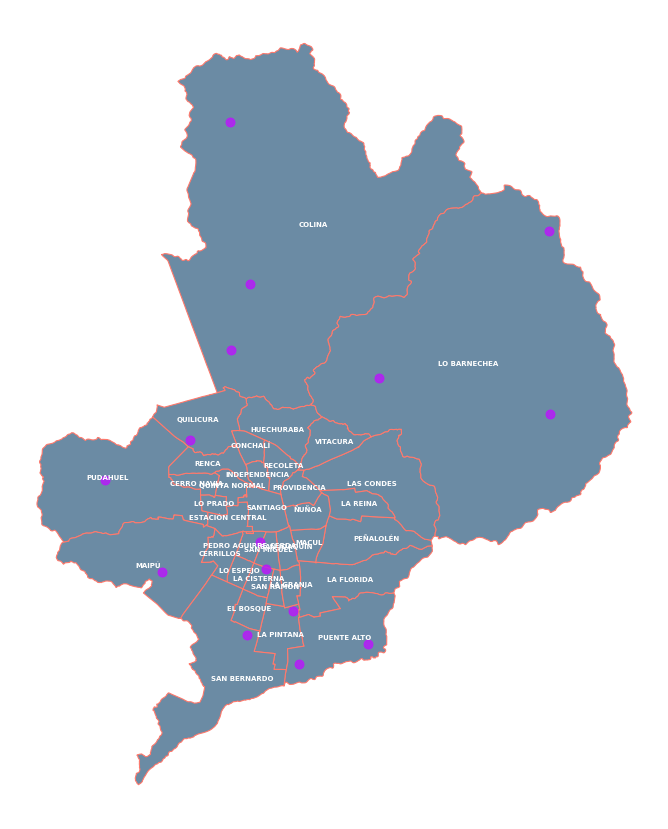

In [41]:
f, ax = plt.subplots(1, figsize=(15, 15))
comunas_sel.plot(linewidth=1.1, facecolor='xkcd:grey blue', edgecolor='xkcd:salmon', ax=ax)
texts = [ax.text(row.coords[0], row.coords[1], s=row['NOM_COMUNA'], horizontalalignment='center', color='white', weight='bold', fontsize=7,
                bbox={'facecolor': 'none', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}) for idx, row in comunas_sel.iterrows()]
cluster_centers_df.plot.scatter("lon","lat", s=80, c="xkcd:neon purple", alpha=0.8, ax=ax)
# POI_labels.plot.scatter("lon","lat", s=20, c="blue", alpha=0.7, ax=ax)
# ev_rm_clip.plot(ax=ax, color='blue', alpha=0.3)
ax.set_axis_off()